In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [149]:
df = pd.read_csv('data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfYear'] = df['Date'].dt.dayofyear
df['MonthName'] = df['Date'].dt.month_name()
df['WeekOfYear'] = df['Date'].apply(lambda x : x.weekofyear)

df.head()
df['Price'].describe()

count    1476.000000
mean      114.102981
std        20.482524
min        81.000000
25%        99.000000
50%       111.500000
75%       124.000000
max       281.000000
Name: Price, dtype: float64

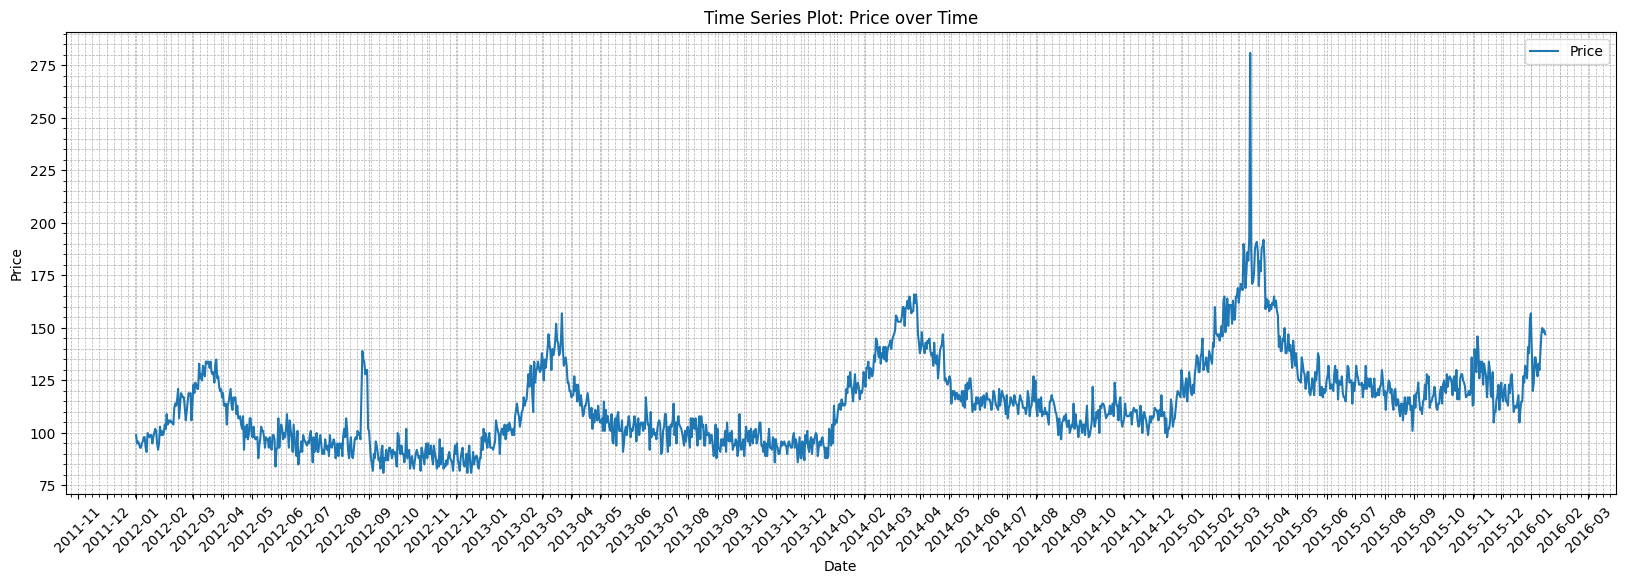

In [150]:
import matplotlib.dates as mdates

plt.figure(figsize=(20, 6))
plt.plot(df['Date'], df['Price'], label='Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Time Series Plot: Price over Time')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.legend()

# Set major ticks to every month and format them
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.show()

### Observation

1) 2016 data is incomplete , only first 16 days of the year , so will not use it for analysis
2) There is a strong seasonality year-on-year which suggests there is a rise in prices around Jan-Feb along with a peak in prices around March every year, after that the prices decline.
3) Visually there are some outliers in the data like (2012-08,2015-4)



## Outlier Detection and Removal

we will use a rolling window mean and standard deviation to detect outliers, first we calculate the rolling mean and std, then find the upper bounds and lower bounds such as -
1) Upper Bound = mean(x)+ n*std(x)
2) Lower Bound = mean(x)- n*std(x) 
- n is a constant that represents the tightness of the bounds.
- Any data points outside the bounds will be classified as an outlier

In [151]:
df=df[df['Year']<2016] # Filter out data from 2016 onwards

rolling_window = 120  # 30-day rolling window

# Calculate the rolling mean and standard deviation
df_rolling = df['Price'].rolling(window=rolling_window).agg(['mean','std'])

# Joining the rolling statistics back to the original DataFrame
df[['Rolling_Mean', 'Rolling_Std']] = df_rolling.rename(columns={'mean': 'Rolling_Mean', 'std': 'Rolling_Std'})
df.tail()



,Date,Price,Year,Month,Day,DayOfYear,MonthName,WeekOfYear,Rolling_Mean,Rolling_Std
1455,2015-12-27,129,2015,12,27,361,December,52,120.558333,7.734889
1456,2015-12-28,126,2015,12,28,362,December,53,120.766667,7.537841
1457,2015-12-29,141,2015,12,29,363,December,53,121.025000,7.695314
1458,2015-12-30,138,2015,12,30,364,December,53,121.191667,7.844385
1459,2015-12-31,154,2015,12,31,365,December,53,121.541667,8.351416


In [152]:
N_SIGMA= 3  # Number of standard deviations for outlier detection
# Calculate the upper and lower bounds for outlier detection
df['Upper_Bound'] = df['Rolling_Mean'] + N_SIGMA * df['Rolling_Std']
df['Lower_Bound'] = df['Rolling_Mean'] - N_SIGMA * df['Rolling_Std']

# Highlight outliers
df['outliers'] = ((df['Price'].astype('float') > df['Upper_Bound']) | (df['Price'].astype('float') < df['Lower_Bound']))
df_outliers = df[df['outliers']]
df.tail()

,Date,Price,Year,Month,Day,DayOfYear,MonthName,WeekOfYear,Rolling_Mean,Rolling_Std,Upper_Bound,Lower_Bound,outliers
1455,2015-12-27,129,2015,12,27,361,December,52,120.558333,7.734889,143.762999,97.353668,False
1456,2015-12-28,126,2015,12,28,362,December,53,120.766667,7.537841,143.380190,98.153144,False
1457,2015-12-29,141,2015,12,29,363,December,53,121.025000,7.695314,144.110942,97.939058,False
1458,2015-12-30,138,2015,12,30,364,December,53,121.191667,7.844385,144.724823,97.658510,False
1459,2015-12-31,154,2015,12,31,365,December,53,121.541667,8.351416,146.595915,96.487419,True


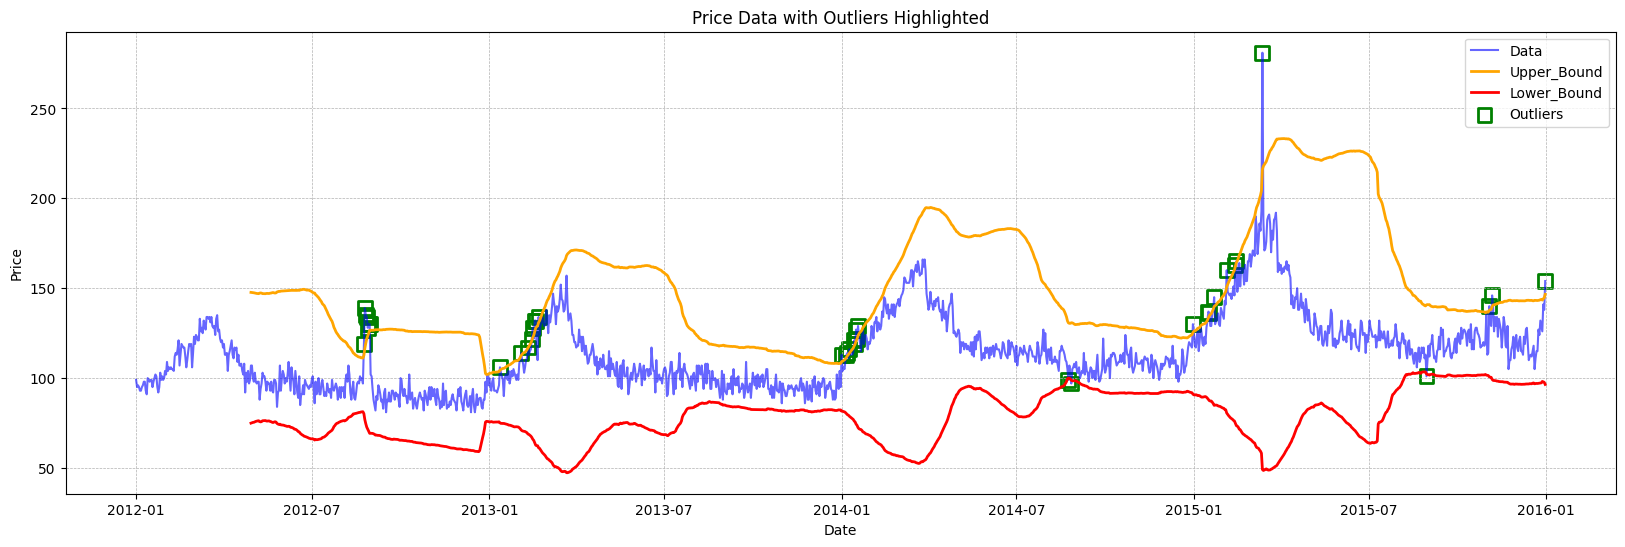

Number of outliers detected: 38
Outliers DataFrame:


,Date,Price,Year,Month,Day,DayOfYear,MonthName,WeekOfYear,Rolling_Mean,Rolling_Std,Upper_Bound,Lower_Bound,outliers
235,2012-08-24,119,2012,8,24,237,August,34,96.408333,5.391397,112.582523,80.234144,True
236,2012-08-25,139,2012,8,25,238,August,34,96.700000,6.613711,116.541134,76.858866,True
237,2012-08-26,135,2012,8,26,239,August,34,97.016667,7.481050,119.459816,74.573517,True
238,2012-08-27,134,2012,8,27,240,August,35,97.308333,8.206163,121.926821,72.689845,True
239,2012-08-28,128,2012,8,28,241,August,35,97.483333,8.627670,123.366344,71.600322,True
240,2012-08-29,130,2012,8,29,242,August,35,97.675000,9.084258,124.927773,70.422227,True
241,2012-08-30,130,2012,8,30,243,August,35,97.925000,9.549660,126.573980,69.276020,True
376,2013-01-12,106,2013,1,12,12,January,2,89.741667,4.874037,104.363776,75.119557,True
398,2013-02-03,114,2013,2,3,34,February,5,91.850000,6.913207,112.589622,71.110378,True
405,2013-02-10,117,2013,2,10,41,February,6,92.908333,8.009444,116.936665,68.880002,True


In [153]:
# Plot the data with outliers highlighted along with the upper and lower bounds

plt.figure(figsize=(20, 6))
plt.plot(df['Date'], df['Price'], color='blue', label='Data', alpha=0.6)
plt.plot(df['Date'], df['Upper_Bound'], color='orange', label='Upper_Bound', linewidth=2)
plt.plot(df['Date'], df['Lower_Bound'], color='red', label='Lower_Bound', linewidth=2)
plt.scatter(df[df['outliers']]['Date'], df[df['outliers']]['Price'], 
      facecolors='none', edgecolors='green', s=100, label='Outliers', marker='s', linewidths=2)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Data with Outliers Highlighted')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()
print("Number of outliers detected:", df_outliers.shape[0])
print("Outliers DataFrame:")
df_outliers

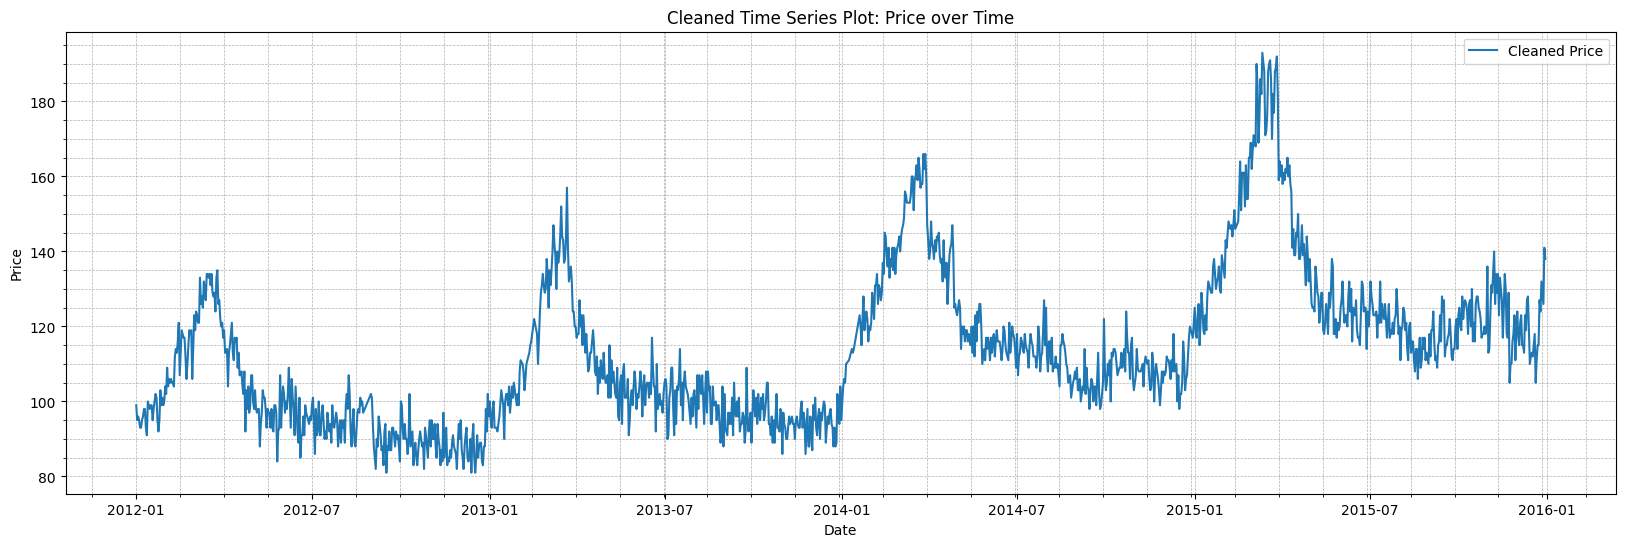

In [154]:
# remove outliers from the DataFrame
df = df[~df['outliers']]


#plot the cleaned data
plt.figure(figsize=(20, 6))
plt.plot(df['Date'], df['Price'], label='Cleaned Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Cleaned Time Series Plot: Price over Time')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.legend()
plt.show()

df = df.drop(columns=['Upper_Bound', 'Lower_Bound', 'outliers', 'Rolling_Mean', 'Rolling_Std', 'Year', 'Month', 'Day', 'DayOfYear', 'MonthName', 'WeekOfYear'])
# Save the cleaned DataFrame to a new CSV file
df.to_csv('cleaned_data.csv', index=False)
